In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import gc
import lightgbm as lgb
import catboost as cb
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, KFold
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [40]:
train_df = pd.read_csv('./data/train.csv')
temp_df = train_df.copy()
og_train_df= train_df.copy()

test_df= pd.read_csv('./data/test.csv')

# Exploratory Data Analysis (EDA)

In [16]:
train_df.head(8)


,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1
5,518279,54513,61900,89.66,67,22807,45,1501,08-09-90,Self employed,...,0,0,1347,0,0,0,1yrs 9mon,2yrs 0mon,0,0
6,529269,46349,61500,76.42,67,22807,45,1502,01-06-88,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
7,510278,43894,61900,71.89,67,22807,45,1501,04-10-89,Salaried,...,0,0,0,0,0,0,0yrs 2mon,0yrs 2mon,0,0


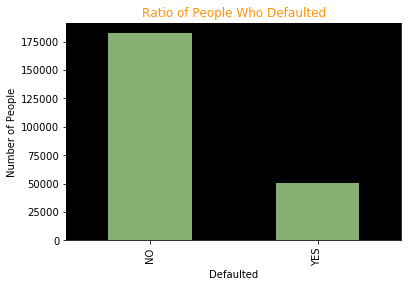

In [7]:
plot_fig = plt.figure()
plot_axes = plt.axes()
plot_axes.set_facecolor('black')

the_target = temp_df['loan_default']
the_target.replace(to_replace=[1, 0], value=['YES', 'NO'], inplace=True)

plt.title('Ratio of People Who Defaulted',color= 'xkcd:tangerine')
plot_axes = plot_axes.set(xlabel='Defaulted', ylabel='Number of People')
the_target.value_counts().plot.bar(color='xkcd:sage')

plt.show()


In [22]:
train_df.isnull().sum(), train_df.shape


(UniqueID                                  0
 disbursed_amount                          0
 asset_cost                                0
 ltv                                       0
 branch_id                                 0
 supplier_id                               0
 manufacturer_id                           0
 Current_pincode_ID                        0
 Date.of.Birth                             0
 Employment.Type                        7661
 DisbursalDate                             0
 State_ID                                  0
 Employee_code_ID                          0
 MobileNo_Avl_Flag                         0
 Aadhar_flag                               0
 PAN_flag                                  0
 VoterID_flag                              0
 Driving_flag                              0
 Passport_flag                             0
 PERFORM_CNS.SCORE                         0
 PERFORM_CNS.SCORE.DESCRIPTION             0
 PRI.NO.OF.ACCTS                           0
 PRI.ACTIV

In [23]:
test_df.isnull().sum(), test_df.shape


(UniqueID                                  0
 disbursed_amount                          0
 asset_cost                                0
 ltv                                       0
 branch_id                                 0
 supplier_id                               0
 manufacturer_id                           0
 Current_pincode_ID                        0
 Date.of.Birth                             0
 Employment.Type                        3443
 DisbursalDate                             0
 State_ID                                  0
 Employee_code_ID                          0
 MobileNo_Avl_Flag                         0
 Aadhar_flag                               0
 PAN_flag                                  0
 VoterID_flag                              0
 Driving_flag                              0
 Passport_flag                             0
 PERFORM_CNS.SCORE                         0
 PERFORM_CNS.SCORE.DESCRIPTION             0
 PRI.NO.OF.ACCTS                           0
 PRI.ACTIV

## Correlation Matrix calculation


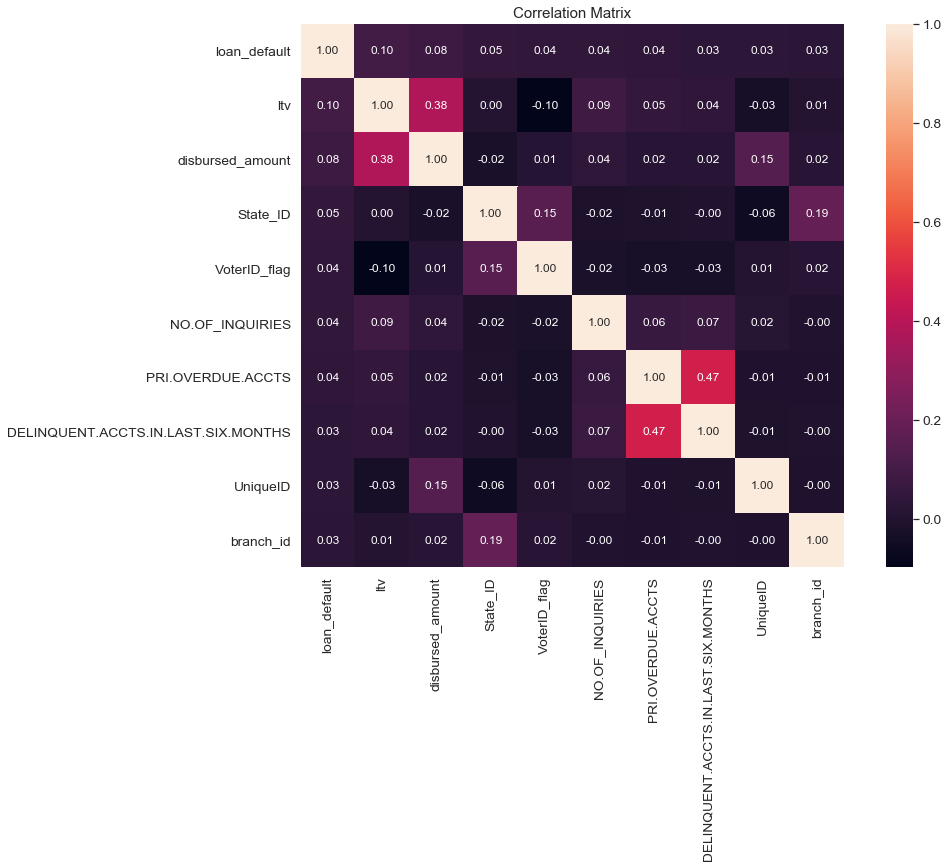

In [9]:
k = 10
correlation_mx = train_df.corr()

fig2=plt.figure()
sns.set(rc={'figure.figsize':(15,10)})

cols = correlation_mx.nlargest(k, 'loan_default')['loan_default'].index
cm = np.corrcoef(train_df[cols].values.T)

sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12}, yticklabels=cols.values, xticklabels=cols.values)

plt.title('Correlation Matrix')
plt.show()

#### Sorted Pearson correlation coefficient

In [10]:
correlation_mx['loan_default'].sort_values(ascending = False)


loan_default                           1.000000
ltv                                    0.098208
disbursed_amount                       0.077675
State_ID                               0.048075
VoterID_flag                           0.043747
NO.OF_INQUIRIES                        0.043678
PRI.OVERDUE.ACCTS                      0.040872
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS    0.034462
UniqueID                               0.033848
branch_id                              0.030193
Current_pincode_ID                     0.028419
supplier_id                            0.027357
Employee_code_ID                       0.020657
asset_cost                             0.014261
PAN_flag                               0.002046
SEC.OVERDUE.ACCTS                     -0.001371
SEC.INSTAL.AMT                        -0.001548
SEC.CURRENT.BALANCE                   -0.005531
Driving_flag                          -0.005821
SEC.ACTIVE.ACCTS                      -0.005993
SEC.DISBURSED.AMOUNT                  -0

#### The most correlated variables are:

- Adhar_flag & VoterID_flag. (-0.9)
- New Accts in last 6 months & PRI Active Accts.(0.7)
- Disbursed_Amount & Asset_cost.(0.7)
- SEC. No. of Accts & SEC.Active Accts. (1.0)
- SEC. Current Balance & SEC Sanctioned Amount. (0.9)
- SEC. Current Balance & SEC. Disbursed Amount. (0.9)
- SEC Sanctioned Amount & SEC. Disbursed Amount. (1.0)
- PRI Sanctioned Amount & PRI Disbursed Amount. (1.0)
- PRI No. of Accts & PRI Active Accts. (0.8)



### Data Preperation

In [28]:
def preprocess_score(x):
    if 'Not Scored' in x or 'No Bureau History Available' in x:
        return 'Not Scored'
    else:
        return x

def preprocess_years(x):
    x_yrs = x.split()[0]
    x_mon = x.split()[1]
    n_years = x_yrs[:(len(x_yrs) - 3)]
    n_mon = x_mon[:(len(x_mon) - 3)]
    return int(n_years) * 12 + int(n_mon)

def preprocess_birth(x):
    if x[6:] != '00':
        x = x[:6] + '19' + x[6:]
    else:
        x = x[:6] + '2000'
    return x

def map_by_mean(var, by, func='mean'):
    if type(by) != list:
        by = [by]
    name = '{0}_by_{1}_mean'.format(var, by)
    grp = df.groupby(by)[[var]].agg(func)
    grp.columns = [name]
    return pd.merge(df[by], grp, left_on=by, right_index=True, how='left')[name]


In [41]:
target = og_train_df['loan_default']
del og_train_df['loan_default']
df = pd.concat((train_df, test_df))
gc.collect()

c:\users\aashith\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


60

In [42]:
# Removing columns with only one unique value
for col in df.columns:
    if df[col].nunique() == 1:
        df.drop(col, axis=1, inplace=True)
        print(f'{col} dropped, nunique=1')

MobileNo_Avl_Flag dropped, nunique=1


### Feature Engineering

In [45]:
df['Date.of.Birth'] = pd.to_datetime(df['Date.of.Birth'], format='%d-%m-%Y', cache=True, errors='coerce')

df['Date.of.Birth'] = pd.to_datetime(df['Date.of.Birth'], format='%d-%m-%Y', cache=True, errors='coerce')

df['DisbursalDate'] = pd.to_datetime(df['DisbursalDate'], format='%d-%m-%y', cache=True)

df['PERFORM_CNS.SCORE.DESCRIPTION'] = df['PERFORM_CNS.SCORE.DESCRIPTION'].apply(preprocess_score)

df['AVERAGE.ACCT.AGE'] = df['AVERAGE.ACCT.AGE'].apply(preprocess_years)

df['CREDIT.HISTORY.LENGTH'] = df['CREDIT.HISTORY.LENGTH'].apply(preprocess_years)

#### Generating some new useful features

In [47]:
df['dayofweek'] = df['DisbursalDate'].dt.weekday
df['day'] = df['DisbursalDate'].dt.day
df['share_overdue'] = df['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'] - df['NEW.ACCTS.IN.LAST.SIX.MONTHS']

df['years_on_loan'] = (df['DisbursalDate'] - df['Date.of.Birth']).astype('timedelta64[Y]')
df['dis_as_diff'] = df['asset_cost'] - df['disbursed_amount']
df['dis_as_share'] = df['asset_cost'] / df['disbursed_amount']
df['diff_ltv_'] = df['dis_as_share'] - df['ltv']

df['sec_overdue_share'] = df['SEC.OVERDUE.ACCTS'] / df['SEC.NO.OF.ACCTS']
df['pri_overdue_share'] = df['PRI.OVERDUE.ACCTS'] / df['PRI.NO.OF.ACCTS']

df['outstanding_now'] = df['disbursed_amount'] + df['PRI.CURRENT.BALANCE']
df['disbursed_tot'] = df['PRI.DISBURSED.AMOUNT'] + df['disbursed_amount']
df['out_to_disbursed'] = df['outstanding_now'] / df['disbursed_tot']

#### Defining Categorical and Numeric feature columns

In [52]:
cat_feature_col = ['branch_id', 'supplier_id',  'manufacturer_id',
                  'Employment.Type', 'State_ID', 'Employee_code_ID',
                  'PERFORM_CNS.SCORE.DESCRIPTION', 'Current_pincode_ID', 'years_on_loan']

numeric_col = ['disbursed_amount', 'asset_cost', 'ltv',
                'PERFORM_CNS.SCORE', 'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
                'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES', 'pri_overdue_share']

# additional check
numeric_col = [x for x in numeric_col if x not in cat_feature_col]

In [53]:
# fill NA with a random str value

df['Employment.Type'].fillna('Missed', inplace=True)

In [54]:
# calculate means by categorical features

for name in cat_feature_col:
    temp = df.groupby([name])[numeric_col].mean()
    temp.columns = [col+'_grpd_by_'+name for col in temp.columns]
    temp = temp.reset_index()
    df = df.merge(temp, how='left', on=name)

In [55]:
# calculating by group the difference between the mean and the real value

grouped_cols = [col for col in df.columns if 'grpd' in col]

for col in grouped_cols:
    numcol = col.split('_grpd_by_')[0]
    df[col] = df[numcol] - df[col]

### Combinatorial Features and Frequency Encoding for categories

In [56]:
# freq encoding

for col in cat_feature_col:
    df[col] = df[col].map(df[col].value_counts(normalize=True))

In [58]:
df['scr_by_sup_man'] = df['PERFORM_CNS.SCORE'] / map_by_mean('PERFORM_CNS.SCORE', ['supplier_id',  'manufacturer_id'])
df['ltv_by_sup_man'] = df['ltv'] / map_by_mean('ltv', ['supplier_id',  'manufacturer_id'])

df['scr_by_sup_branch'] = df['PERFORM_CNS.SCORE'] / map_by_mean('PERFORM_CNS.SCORE', ['supplier_id',  'branch_id'])
df['ltv_by_sup_branch'] = df['ltv'] / map_by_mean('ltv', ['supplier_id',  'branch_id'])

df['scr_by_man_branch'] = df['PERFORM_CNS.SCORE'] / map_by_mean('PERFORM_CNS.SCORE', ['manufacturer_id',  'branch_id'])
df['ltv_by_man_branch'] = df['ltv'] / map_by_mean('ltv', ['manufacturer_id',  'branch_id'])

In [59]:
df['scr_by_man_branch_sup'] = df['PERFORM_CNS.SCORE'] / map_by_mean('PERFORM_CNS.SCORE', ['manufacturer_id',
                                                                                            'branch_id',
                                                                                            'supplier_id'])
df['ltv_by_man_branch_sup'] = df['ltv'] / map_by_mean('ltv', ['manufacturer_id',
                                                                'branch_id',
                                                                'supplier_id'])

df['scr_by_state_branch'] = df['PERFORM_CNS.SCORE'] / map_by_mean('PERFORM_CNS.SCORE', ['State_ID',  'branch_id'])
df['ltv_by_state_branch'] = df['ltv'] / map_by_mean('ltv', ['State_ID',  'branch_id'])

df['scr_by_state_man'] = df['PERFORM_CNS.SCORE'] / map_by_mean('PERFORM_CNS.SCORE', ['State_ID',  'manufacturer_id'])
df['ltv_by_state_man'] = df['ltv'] / map_by_mean('ltv', ['State_ID',  'manufacturer_id'])

In [60]:
df['scr_by_state_sup'] = df['PERFORM_CNS.SCORE'] / map_by_mean('PERFORM_CNS.SCORE', ['State_ID',  'supplier_id'])
df['ltv_by_state_sup'] = df['ltv'] / map_by_mean('ltv', ['State_ID',  'supplier_id'])

df['scr_by_emp_branch'] = df['PERFORM_CNS.SCORE'] / map_by_mean('PERFORM_CNS.SCORE', ['Employee_code_ID',  'branch_id'])
df['ltv_by_emp_branch'] = df['ltv'] / map_by_mean('ltv', ['Employee_code_ID',  'branch_id'])

df['scr_by_sup_emp'] = df['PERFORM_CNS.SCORE'] / map_by_mean('PERFORM_CNS.SCORE', ['Employee_code_ID',  'supplier_id'])
df['ltv_by_sup_emp'] = df['ltv'] / map_by_mean('ltv', ['Employee_code_ID',  'supplier_id'])
df['scr_by_emp_branch_sup'] = df['PERFORM_CNS.SCORE'] / map_by_mean('PERFORM_CNS.SCORE', ['Employee_code_ID',
                                                                                            'branch_id',
                                                                                            'supplier_id'])

In [62]:
df['ltv_by_emp_branch_sup'] = df['ltv'] / map_by_mean('ltv', ['Employee_code_ID',
                                                                'branch_id',
                                                                'supplier_id'])

df['inq_by_sup_man'] = df['NO.OF_INQUIRIES'] / map_by_mean('NO.OF_INQUIRIES', ['supplier_id',  'manufacturer_id'])

df['inq_by_sup_branch'] = df['NO.OF_INQUIRIES'] / map_by_mean('NO.OF_INQUIRIES', ['supplier_id',  'branch_id'])

df['inq_by_man_branch'] = df['NO.OF_INQUIRIES'] / map_by_mean('disbursed_amount', ['manufacturer_id',  'branch_id'])

df['inq_by_man_branch_sup'] = df['NO.OF_INQUIRIES'] / map_by_mean('NO.OF_INQUIRIES', ['manufacturer_id','branch_id','supplier_id'])
df['inq_by_emp_branch'] = df['NO.OF_INQUIRIES'] / map_by_mean('NO.OF_INQUIRIES', ['Employee_code_ID',  'branch_id'])

df['scr_by_age_emptype'] = df['PERFORM_CNS.SCORE'] / map_by_mean('PERFORM_CNS.SCORE', ['Employment.Type',
                                                                                         'years_on_loan'])
df['ltv_by_age_emptype'] = df['ltv'] / map_by_mean('ltv', ['Employment.Type', 'years_on_loan'])

In [65]:
# splitting to train and test again
train_data = df.iloc[:len(train_df), :]
test_data = df.iloc[len(train_df):, :]
train_data['loan_default'] = target


c:\users\aashith\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### Cross Validation

In [66]:
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=138)

oof = train_data[['UniqueID', 'loan_default']]
oof['predict'] = 0

predictions = test_data[['UniqueID']]
val_aucs = []

c:\users\aashith\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [67]:
features = [col for col in train_data.columns if col not in ['UniqueID', 'loan_default', 'Date.of.Birth', 'DisbursalDate']]
X_test = test_data[features].values

In [68]:
# Using LGBM Classifier
lgb_clf = lgb.LGBMClassifier(
                              boosting_type= 'gbdt',
                              learning_rate= 0.05,
                              n_estimators= 750,
                              num_leaves= 16,
                              objective= 'binary',
                              reg_lambda= 5,
                              seed= 15,
                              subsample= 0.5,
                              colsample_bytree=0.5
                              )

### Training the data

In [70]:
for fold, (trn_idx, val_idx) in enumerate(skfold.split(train_data, train_data['loan_default'])):
    
    X_train, y_train = train_data.iloc[trn_idx][features], train_data.iloc[trn_idx]['loan_default']
    X_valid, y_valid = train_data.iloc[val_idx][features], train_data.iloc[val_idx]['loan_default']

    p_valid, yp = 0, 0

    lgb_clf.fit(X_train, y_train)
    p_valid += lgb_clf.predict_proba(X_valid)[:, 1]
    yp += lgb_clf.predict_proba(X_test)[:, 1]

    oof['predict'][val_idx] = p_valid
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)

    predictions['fold{}'.format(fold + 1)] = yp

In [71]:
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['loan_default'], oof['predict'])

print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

Mean auc: 0.670651728, std: 0.002432613. All auc: 0.670628549.


In [72]:
# Making Predictions

predictions['loan_default'] = np.mean(predictions[[col for col in predictions.columns if col not in ['UniqueID', 'loan_default']]].values, axis=1)
predictions.to_csv('./data/lgb_all_predictions_wmean1_mod3.csv', index=None)